<a href="https://www.kaggle.com/code/fotimakhongulomova/neural-network-classification?scriptVersionId=186355311" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Neural Network Classification with Pytorch

Classification is a problem of predicting whether something is one thing or another (there can be nultiple things as the options).

## 1. Make classification data and get it ready

In [1]:
import sklearn 
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_circles

torch.__version__

'2.1.2'

In [2]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [5]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "labels": y})
circles.head()

,X1,X2,labels
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


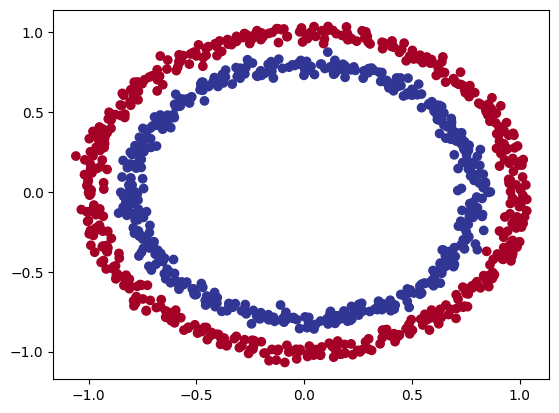

In [6]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

### 1.2 Turn data into tensors and create train and test splits

In [9]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [12]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
n_samples

1000

## 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agonistic code so our code will run on an acclerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [15]:
# Make device agnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

### Model:
1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instatiate an instance of our model class and send it to the target `device`

In [17]:
from sklearn import datasets

# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layesrs capable of hadling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    
# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2602, -0.3049],
                      [ 0.4919,  0.6819],
                      [-0.2498, -0.1578],
                      [-0.2949,  0.0246],
                      [-0.5795,  0.2980]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0656, -0.1041, -0.3443, -0.3666,  0.1379], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1808,  0.0424, -0.3811,  0.2286, -0.0719]], device='cuda:0')),
             ('1.bias', tensor([0.2572], device='cuda:0'))])

In [20]:
# Make predictions 
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n{untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[0.3145],
        [0.4038],
        [0.1415],
        [0.3633],
        [0.2383],
        [0.2920],
        [0.4667],
        [0.4407],
        [0.1376],
        [0.4109]], device='cuda:0')

First 10 labels: 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

In [21]:
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function buil-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [22]:
# Calculate accuracy 
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## 3. Train a model

1. Forward pass
2. Calculate the loss
3. Optimer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

In [23]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
    
y_logits

tensor([[0.3145],
        [0.4038],
        [0.1415],
        [0.3633],
        [0.2383]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use sigmoid activation function on our model
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5780],
        [0.5996],
        [0.5353],
        [0.5898],
        [0.5593]], device='cuda:0')

In [26]:
# find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_probs.squeeze()))
y_preds.squeeze()

tensor([False, False, False, False, False], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

## 3.2 Building a training and testing loop

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()
    
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Loss: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70338, Acc: 50.00% | Test loss: 0.70864, Test Loss: 50.00%
Epoch: 10 | Loss: 0.69809, Acc: 50.00% | Test loss: 0.70305, Test Loss: 50.00%
Epoch: 20 | Loss: 0.69557, Acc: 59.62% | Test loss: 0.70018, Test Loss: 55.00%
Epoch: 30 | Loss: 0.69436, Acc: 54.62% | Test loss: 0.69862, Test Loss: 48.00%
Epoch: 40 | Loss: 0.69376, Acc: 52.75% | Test loss: 0.69771, Test Loss: 48.00%
Epoch: 50 | Loss: 0.69345, Acc: 52.75% | Test loss: 0.69713, Test Loss: 47.00%
Epoch: 60 | Loss: 0.69328, Acc: 52.00% | Test loss: 0.69672, Test Loss: 46.00%
Epoch: 70 | Loss: 0.69319, Acc: 51.75% | Test loss: 0.69642, Test Loss: 46.50%
Epoch: 80 | Loss: 0.69313, Acc: 51.75% | Test loss: 0.69617, Test Loss: 47.50%
Epoch: 90 | Loss: 0.69309, Acc: 51.75% | Test loss: 0.69597, Test Loss: 46.50%


## 4. Make predictions and evaluate the model

In [29]:
import requests
from pathlib import Path

# Dowland helper functions from Learn Pytorch repo 

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")

else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


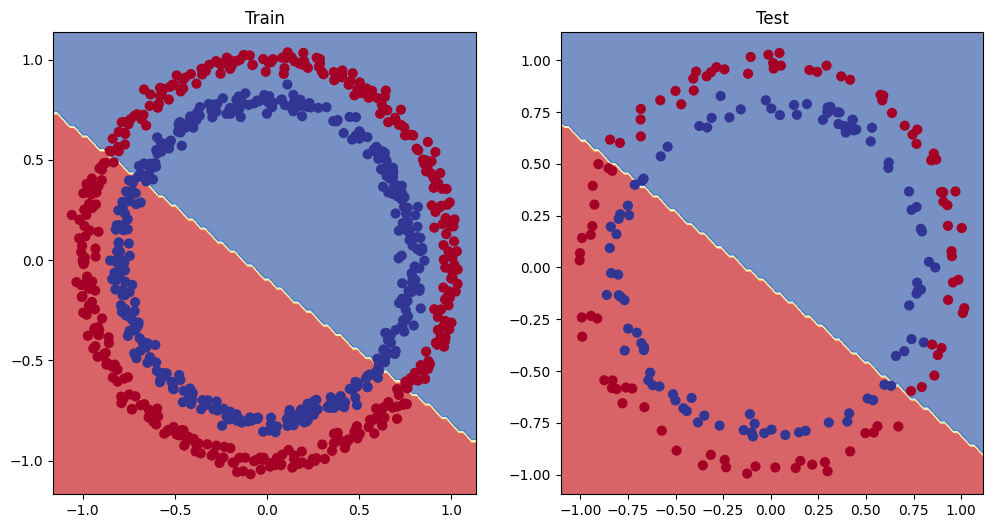

In [30]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers 
* Add more hidden units
* Fit for longer
* Change the activation functions
* Change the learning rate
* Change the loss function

In [31]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.2490, -0.2975],
                      [ 0.4902,  0.6809],
                      [-0.2286, -0.1439],
                      [-0.3129,  0.0126],
                      [-0.5746,  0.3012]])),
             ('0.bias', tensor([ 0.0973, -0.1100, -0.2829, -0.4141,  0.1515])),
             ('1.weight',
              tensor([[-0.1664,  0.0016, -0.3039,  0.3161, -0.0734]])),
             ('1.bias', tensor([0.0796]))])

In [32]:
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=1),
).to(device)

model_1

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function buil-in
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 30

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()
    
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backward (backpropagation)
    loss.backward()
    
    # 5. Optimizer step (gradient descent)
    optimizer.step()
    
    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test Loss: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69146, Acc: 59.38% | Test loss: 0.68962, Test Loss: 50.00%
Epoch: 10 | Loss: 0.64434, Acc: 83.25% | Test loss: 0.64552, Test Loss: 79.00%
Epoch: 20 | Loss: 0.50155, Acc: 99.00% | Test loss: 0.51132, Test Loss: 97.00%


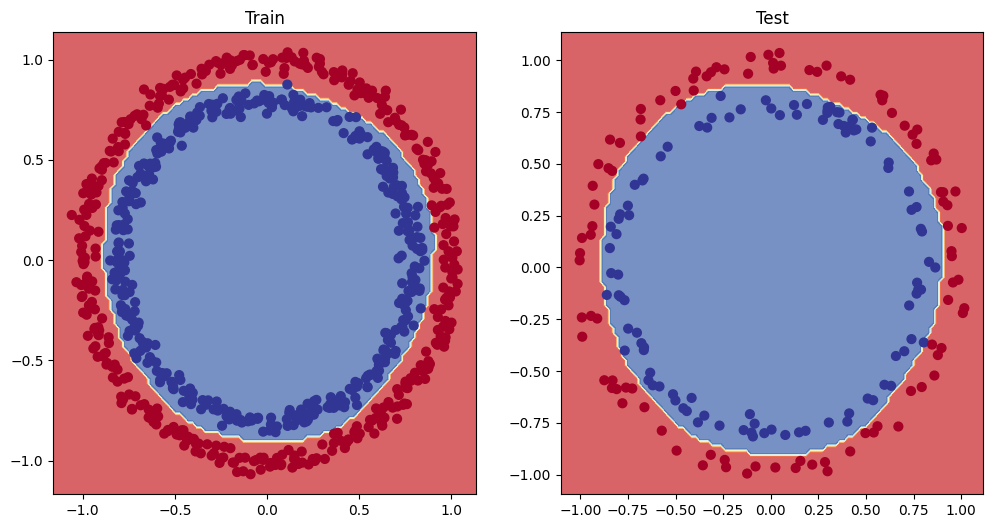

In [34]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [35]:
# 11:15:05